In [1]:
import matplotlib.pyplot as plt
import os

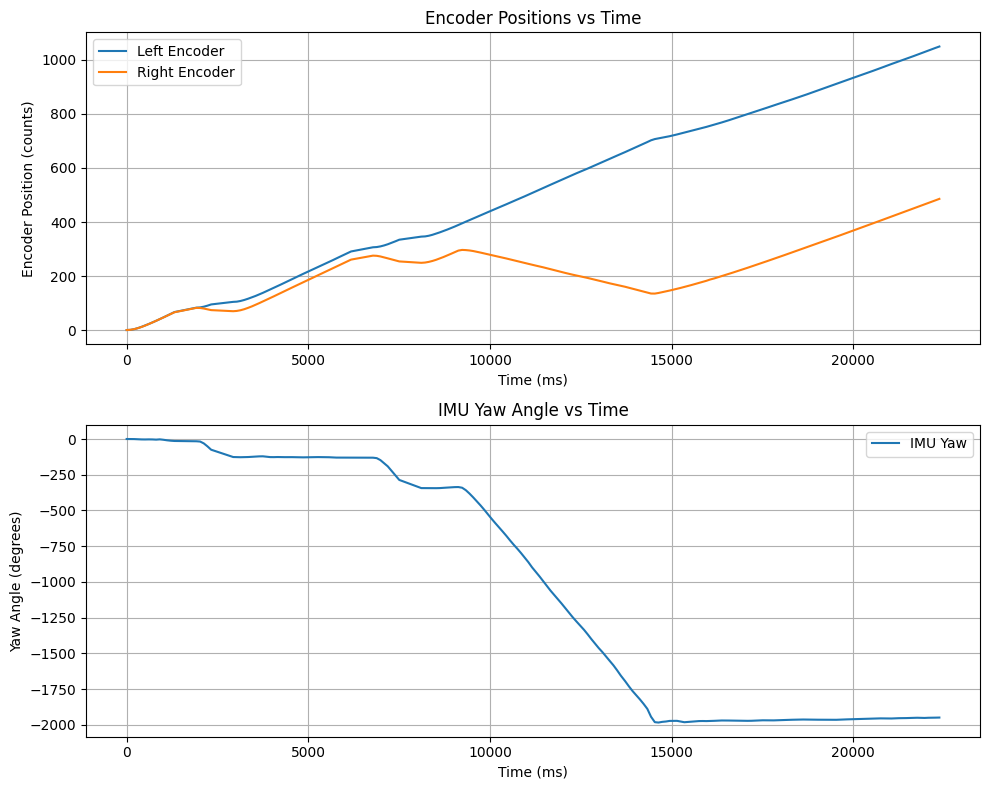

In [4]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'l4data.csv')


with open(data_path, 'r') as f:
    data = f.readlines()

# Parse the CSV data into lists
times = []
left_positions = []
right_positions = [] 
yaws = []

for line in data:
    t, l, r, y = line.strip().split(',')
    times.append(float(t))
    left_positions.append(float(l))
    right_positions.append(float(r))
    yaws.append(float(y))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Plot encoder positions
ax1.plot(times, left_positions, label='Left Encoder')
ax1.plot(times, right_positions, label='Right Encoder')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Encoder Position (counts)')
ax1.legend()
ax1.grid(True)
ax1.set_title('Encoder Positions vs Time')

# Plot IMU yaw angle
ax2.plot(times, yaws, label='IMU Yaw')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Yaw Angle (degrees)')
ax2.legend()
ax2.grid(True)
ax2.set_title('IMU Yaw Angle vs Time')

plt.tight_layout()
plt.show()

